In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:

train_dir = "train"
validation_dir = "test"

BATCH_SIZE = 32
IMG_SIZE = (64, 64)

train_dataset = image_dataset_from_directory(
    train_dir,label_mode='categorical', shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE
)


validation_dataset = image_dataset_from_directory(
    validation_dir,label_mode='categorical', shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE
)


class_names = train_dataset.class_names


Found 4800 files belonging to 4 classes.
Found 1600 files belonging to 4 classes.


In [3]:
class_names

['berry', 'bird', 'dog', 'flower']

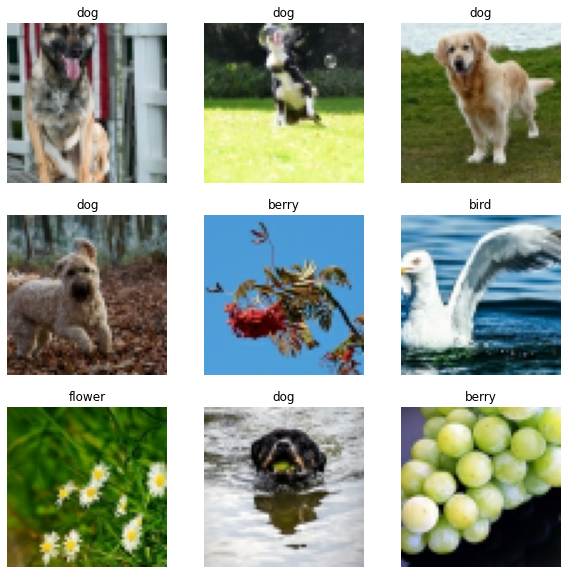

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

Number of validation batches: 40
Number of test batches: 10


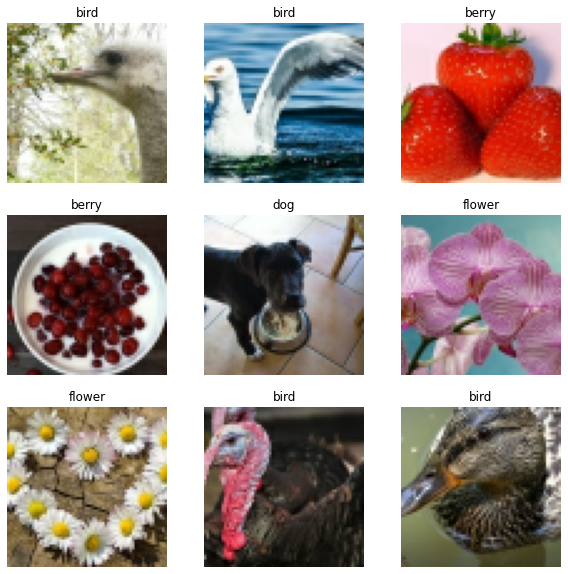

In [5]:

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")


val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)


print("Number of validation batches: %d" % tf.data.experimental.cardinality(validation_dataset))
print("Number of test batches: %d" % tf.data.experimental.cardinality(test_dataset))


data_augmentation = tf.keras.Sequential(
    [
         tf.keras.layers.experimental.preprocessing.RandomFlip("vertical"),
         tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    ]
)


In [6]:
np.argmax(labels[i].numpy())

1

(32, 2, 2, 1280)


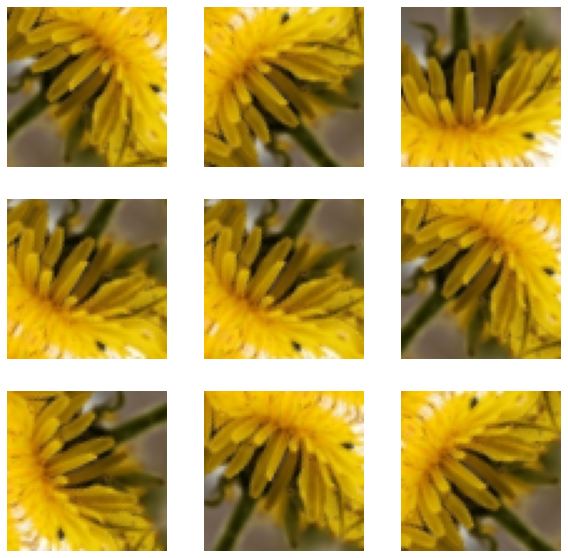

In [7]:


for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis("off")

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 127.5, offset=-1)

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

base_model.trainable = False


In [8]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 32, 32, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 32, 32, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 32, 32, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [9]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(len(class_names))
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

inputs = tf.keras.Input(shape=(64, 64, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
model.summary()
len(model.trainable_variables)

(32, 1280)
(32, 4)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 64, 64, 3)         0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 64, 64, 3)         0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 64, 64, 3)         0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 2, 2, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280) 

2

In [10]:

initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)


print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


history = model.fit(train_dataset, epochs=initial_epochs, validation_data=validation_dataset)


acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.ylabel("Accuracy")
plt.ylim([min(plt.ylim()), 1])
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.ylabel("Cross Entropy")
plt.ylim([0, 1.0])
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()


base_model.trainable = True


print("Number of layers in the base model: ", len(base_model.layers))


fine_tune_at = 100


for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate / 10),
    metrics=["accuracy"],
)

40/40 [==============================] - 8s 135ms/step - loss: 2.9132 - accuracy: 0.2700
initial loss: 2.94
initial accuracy: 0.29
Epoch 1/10
 51/150 [=========>....................] - ETA: 14s - loss: 2.2117 - accuracy: 0.3033- ETA: 17s - loss: 2.3538 -

KeyboardInterrupt: 

In [ ]:
crash

In [ ]:
model.summary()

In [ ]:
len(model.trainable_variables)
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

In [ ]:

history_fine = model.fit(
    train_dataset, epochs=total_epochs, initial_epoch=history.epoch[-1], validation_data=validation_dataset
)

In [ ]:

acc += history_fine.history["accuracy"]
val_acc += history_fine.history["val_accuracy"]

loss += history_fine.history["loss"]
val_loss += history_fine.history["val_loss"]


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.ylim([0.8, 1])
plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label="Start Fine Tuning")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.ylim([0, 1.0])
plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label="Start Fine Tuning")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

In [ ]:


loss, accuracy = model.evaluate(test_dataset)
print("Test accuracy :", accuracy)


image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()


predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print("Predictions:\n", predictions.numpy())
print("Labels:\n", label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")



In [ ]:
pred_vec = model.predict(image_batch[[0]])

In [ ]:
np.argmax(pred_vec)

In [ ]:
class_names[np.argmax(pred_vec)]

In [ ]:
model.save('class')

In [11]:
model2 = tf.keras.models.load_model('class')

In [12]:
model2.predict(image_batch[[0]])

ValueError: in user code:

    C:\Users\wslee\anaconda\lib\site-packages\tensorflow\python\keras\engine\training.py:1478 predict_function  *
        return step_function(self, iterator)
    C:\Users\wslee\anaconda\lib\site-packages\tensorflow\python\keras\engine\training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\wslee\anaconda\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\wslee\anaconda\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\wslee\anaconda\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\wslee\anaconda\lib\site-packages\tensorflow\python\keras\engine\training.py:1461 run_step  **
        outputs = model.predict_step(data)
    C:\Users\wslee\anaconda\lib\site-packages\tensorflow\python\keras\engine\training.py:1434 predict_step
        return self(x, training=False)
    C:\Users\wslee\anaconda\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\wslee\anaconda\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:271 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model: expected shape=(None, 64, 64, 3), found shape=(32, 64, 3)


In [14]:
import os 
class_names=os.listdir('train')
from tensorflow.keras.models import load_model
class model:
    def __init__(self):
        self.model = load_model('class')
    def predict(self, image):
        pred_vec=self.model.predict(image)
        return class_names[np.argmax(pred_vec)]

In [17]:
mdl=model()

In [18]:
mdl.predict(image_batch.numpy()[[0]])

'dog'

In [15]:
class_names

['berry', 'bird', 'dog', 'flower']

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
def modeling(image_directory='images', training_epoch=10, finetune_epoch=10):
    model()
    model.train